In [1]:
import torch 
import torchvision
import torchvision.transforms as tr
import torchvision.datasets as dset
from torch.utils.data import DataLoader, Dataset

from torch.autograd import Variable
from torch.autograd import Function

import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random

import visdom
import os

In [2]:
## terminal command : python -m visdom.server
vis = visdom.Visdom()
vis2 = visdom.Visdom()
plot = vis.line(Y=torch.tensor([0]), X=torch.tensor([0]))
plot2= vis2.line(Y=torch.tensor([0]),X=torch.tensor([0]))

Setting up a new session...
Setting up a new session...


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
transf = tr.Compose([tr.Resize((224, 224)),
                     tr.ToTensor(),
                     tr.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 128x128 이미지 크기 변환 후 텐서 제작
image_datasets = torchvision.datasets.ImageFolder(root='./test4_preprocessed', transform=transf) # 4번 검사 데이터 데이터 로딩
print(image_datasets)

Dataset ImageFolder
    Number of datapoints: 250
    Root location: ./test4_preprocessed
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [5]:
class_names = image_datasets.classes
print(class_names)

['Deform&PSV', 'Normal']


In [6]:
train_size = int(0.7 * len(image_datasets))
test_size = len(image_datasets) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
validation_loader = DataLoader(test_dataset, batch_size = 8, shuffle = False)

In [7]:
def imshow(inp, title=None):
    #Imshow for Tensor#
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [8]:
inputs, classes = next(iter(train_loader))
print(classes)

tensor([1, 0, 0, 1, 0, 0, 1, 0])


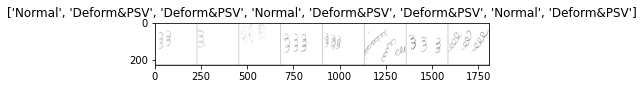

In [9]:
out = torchvision.utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes])

In [10]:
model = torchvision.models.vgg16(pretrained=True)

In [11]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 2)
model = model.to(device)

In [13]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# 손실함수, 최적화 함수 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [15]:
for epoch in range(50):

    running_loss = 0.0
    correct = 0
    for data in train_loader:
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = outputs.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()

    cost = running_loss / len(train_loader)
    
    print('[%d] Train loss: %.3f | Train accuracy: %.2f%%' %(epoch + 1, cost, 100.*correct/len(train_loader.dataset))) 
    
    #test loss 값을 Y축, 전달받은 파라미터 epoch를 X 값으로 
    vis.line(Y=[cost], X=np.array([epoch]),win=plot,update='append')

    # accuracy를 구하는 수식을 Y값으로 epoch를 X값으로 
    vis2.line(Y=[100.*correct/len(train_loader.dataset)], X=np.array([epoch]),win=plot2,update='append')
    
torch.save(model.state_dict(), './models/cropped_test4_vgg16_pretrained.pth')      

print('Finished Training')

[1] Train loss: 0.672 | Train accuracy: 58.86%
[2] Train loss: 0.567 | Train accuracy: 70.86%
[3] Train loss: 0.374 | Train accuracy: 85.14%
[4] Train loss: 0.301 | Train accuracy: 88.57%
[5] Train loss: 0.190 | Train accuracy: 92.00%
[6] Train loss: 0.175 | Train accuracy: 94.29%
[7] Train loss: 0.420 | Train accuracy: 89.71%
[8] Train loss: 0.395 | Train accuracy: 85.14%
[9] Train loss: 0.260 | Train accuracy: 88.00%
[10] Train loss: 0.308 | Train accuracy: 92.00%
[11] Train loss: 0.131 | Train accuracy: 97.14%
[12] Train loss: 0.071 | Train accuracy: 98.29%
[13] Train loss: 0.078 | Train accuracy: 97.71%
[14] Train loss: 0.027 | Train accuracy: 99.43%
[15] Train loss: 0.019 | Train accuracy: 99.43%
[16] Train loss: 0.008 | Train accuracy: 100.00%
[17] Train loss: 0.003 | Train accuracy: 100.00%
[18] Train loss: 0.002 | Train accuracy: 100.00%
[19] Train loss: 0.003 | Train accuracy: 100.00%
[20] Train loss: 0.005 | Train accuracy: 100.00%
[21] Train loss: 0.002 | Train accuracy: 100

In [16]:
model = torchvision.models.vgg16(pretrained=False)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 2)
model = model.to(device)
model.load_state_dict(torch.load('./models/cropped_test4_vgg16_pretrained.pth'))

<All keys matched successfully>

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the test images: 81.33 %


In [18]:
correct = 0
total = 0
with torch.no_grad():
    real_array = []
    pred_array = []
    for data in validation_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        real_array.append(labels.tolist())
        pred_array.append(predicted.tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    real_array = sum(real_array, []) #1차원 리스트로
    pred_array = sum(pred_array, []) #1차원 리스트로
print('Accuracy of the network on the test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the test images: 81.33 %


In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(real_array, pred_array, target_names=['Deform&PSV','Normal']))

              precision    recall  f1-score   support

  Deform&PSV       0.83      0.83      0.83        41
      Normal       0.79      0.79      0.79        34

    accuracy                           0.81        75
   macro avg       0.81      0.81      0.81        75
weighted avg       0.81      0.81      0.81        75



In [ ]:
model = torchvision.models.vgg16(pretrained=False)

In [ ]:
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 4)
model = model.to(device)

In [ ]:
# 손실함수, 최적화 함수 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [ ]:
for epoch in range(50):

    running_loss = 0.0
    correct = 0
    for data in train_loader:
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = outputs.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()

    cost = running_loss / len(train_loader)
    
    print('[%d] Train loss: %.3f | Train accuracy: %.2f%%' %(epoch + 1, cost, 100.*correct/len(train_loader.dataset))) 
    
    #test loss 값을 Y축, 전달받은 파라미터 epoch를 X 값으로 
    vis.line(Y=[cost], X=np.array([epoch]),win=plot,update='append')

    # accuracy를 구하는 수식을 Y값으로 epoch를 X값으로 
    vis2.line(Y=[100.*correct/len(train_loader.dataset)], X=np.array([epoch]),win=plot2,update='append')
    
torch.save(model.state_dict(), './models/test4_vgg16.pth')      

print('Finished Training')

In [ ]:
model = torchvision.models.vgg16(pretrained=False)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 4)
model = model.to(device)
model.load_state_dict(torch.load('./models/test4_vgg16.pth'))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %.2f %%' % (100 * correct / total))